In [1]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import orbax.checkpoint as ocp
from jax import jit, random, vmap
import re
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib import font_manager

# load the font
font_dir = "./fonts/"
font_names = os.listdir(font_dir)
for font_name in font_names:
    font_manager.fontManager.addfont(font_dir + font_name)

rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype"],
    "mathtext.fontset": "cm",
})
jax.config.update("jax_enable_x64", True)  # 启用 float64 精度


In [3]:
import examples.combustion.configs as cfg
from examples.combustion.model import PINN

cfg = cfg.Config()
pinn = PINN(
    config=cfg,
)

ref_path = cfg.DATA_PATH
mesh = jnp.load(f"{cfg.DATA_PATH}/x.npy").reshape(-1, 1) / cfg.Lc

In [4]:
ckpt = ocp.StandardCheckpointer()
state = ckpt.restore("/root/autodl-tmp/tf-logs/combustion/irr/0718-baseline-19800/model-19800/")
state_noirr = ckpt.restore("/root/autodl-tmp/tf-logs/combustion/noirr/0718-baseline/model-19800/")
params = state["params"]
params_noirr = state_noirr["params"]

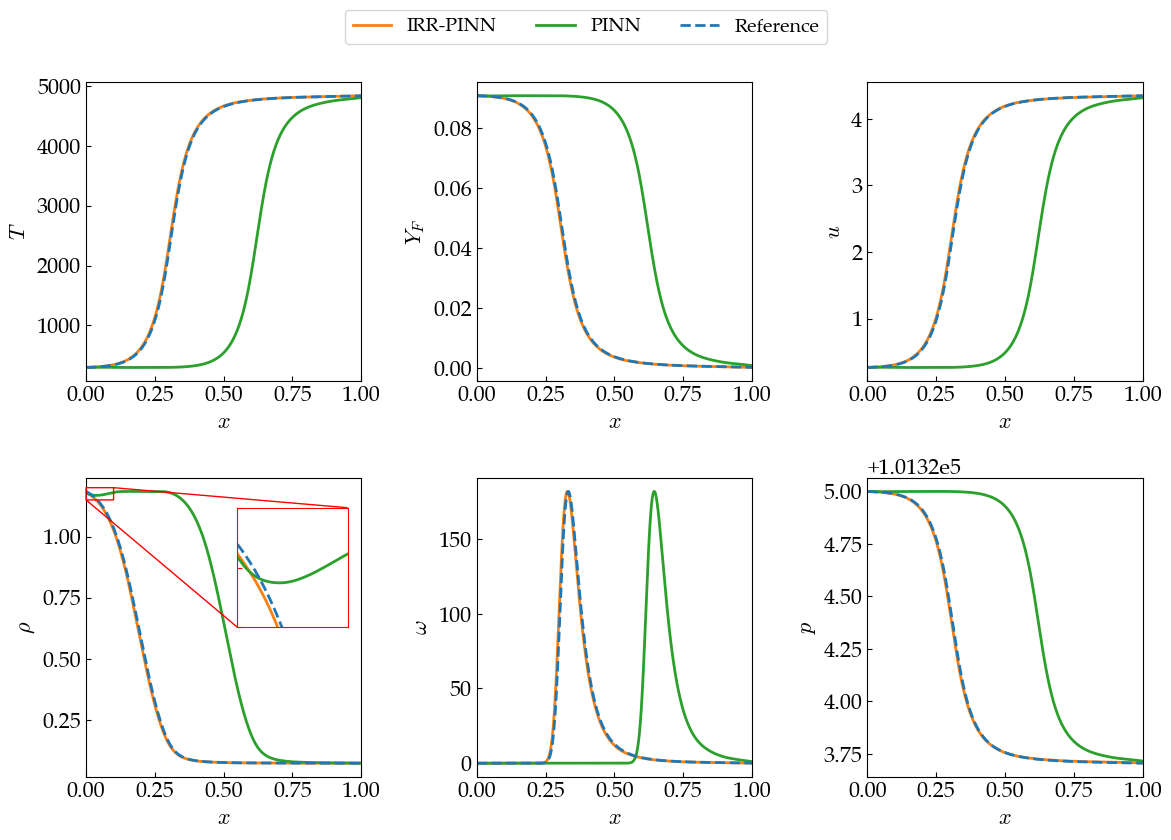

In [31]:
%matplotlib inline
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()


fns = [pinn.net_T, pinn.net_yf, pinn.net_u, pinn.net_rho, pinn.net_omega, pinn.net_p]
math_notations = [
    r"$T$",
    r"$Y_F$",
    r"$u$",
    r"$\rho$",
    r"$\omega$",
    r"$p$"
]
file_paths = [
    f"{ref_path}/T.npy",
    f"{ref_path}/YF.npy",
    f"{ref_path}/u.npy",
    f"{ref_path}/rho.npy",
    f"{ref_path}/omega.npy",
    f"{ref_path}/p.npy"
]
for i, (fn, math_notation, file_path) in enumerate(zip(fns, math_notations, file_paths)):
    ref = jnp.load(file_path)
    pred = vmap(fn, in_axes=(None, 0))(params, mesh).squeeze()
    pred_noirr = vmap(fn, in_axes=(None, 0))(params_noirr, mesh).squeeze()
    ax = axes[i]

    if i == 0:
        ax.plot(mesh, pred,  color="C1", lw=2, label="IRR-PINN")
        ax.plot(mesh, pred_noirr,  color="C2", lw=2, label="PINN")
        ax.plot(mesh, ref,  color="C0", linestyle="--", lw=2, label="Reference")
    else:
        ax.plot(mesh, pred,  color="C1", lw=2)
        ax.plot(mesh, pred_noirr,  color="C2", lw=2)
        ax.plot(mesh, ref,  color="C0", linestyle="--", lw=2)
        if i == 3:
            x1, x2 = 0.0, 0.1
            y1, y2 = 1.15, 1.2
            axin = ax.inset_axes([0.55, 0.5, 0.4, 0.4],
                                 xlim=(x1, x2), ylim=(y1, y2),
                                 xticklabels=[], yticklabels=[])
            # set the color of axin as red
            for spine in axin.spines.values():
                spine.set_edgecolor("red")  # 坐标轴框线颜色
            axin.tick_params(axis="both", colors="red", which="both") 
            axin.plot(mesh, pred,  color="C1", lw=2)
            axin.plot(mesh, pred_noirr,  color="C2", lw=2)
            axin.plot(mesh, ref,  color="C0", linestyle="--", lw=2)
            ax.indicate_inset_zoom(axin, edgecolor="red", linewidth=1, alpha=1)
    ax.set_xlabel("$x$")
    ax.set_xlim(0, 1)
    ax.set_ylabel(math_notation)
    



# fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.tight_layout()
fig.legend(loc='lower center', ncol=3, fontsize=14, bbox_to_anchor=(0.5, 1.0))
plt.savefig("figures/combustion-solution.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/combustion-solution.pdf", bbox_inches="tight")

In [12]:
epochs = jnp.arange(0, 20000, 200)
error_log = []
error_log_noirr = []

@jit
def pred_fn(params, x,):
    return vmap(pinn.net_T, in_axes=(None, 0))(params, x).squeeze()
sol = jnp.load(f"{ref_path}/T.npy").reshape(-1)

for epoch in epochs:
    state = ckpt.restore(f"/root/autodl-tmp/tf-logs/combustion/irr/0718-baseline-19800/model-{epoch}/")
    state_noirr = ckpt.restore(f"/root/autodl-tmp/tf-logs/combustion/noirr/0718-baseline/model-{epoch}/")
    params = state["params"]
    params_noirr = state_noirr["params"]
    pred = pred_fn(params, mesh).reshape(-1)
    pred_noirr = pred_fn(params_noirr, mesh).reshape(-1)
    error = jnp.mean((pred - sol) ** 2) / jnp.mean(sol ** 2)
    error_noirr = jnp.mean((pred_noirr - sol) ** 2) / jnp.mean(sol ** 2)
    error_log.append(error)
    error_log_noirr.append(error_noirr)
    

The final relative L2 error of IRR-PINN is 5.86e-05
The final relative L2 error of PINN is 3.01e-01


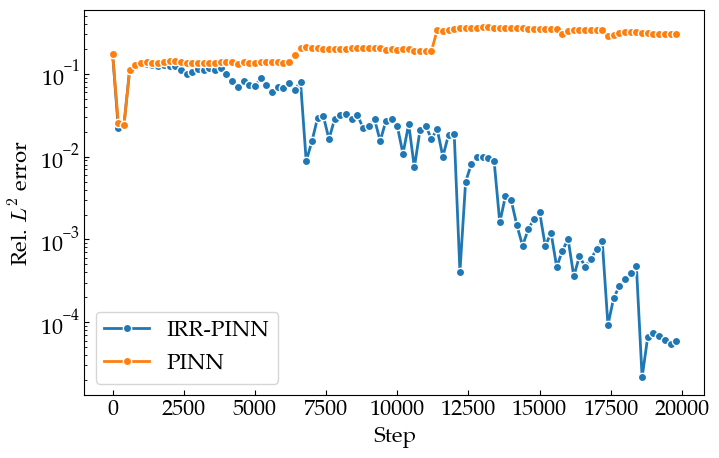

In [7]:
import pandas as pd


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(epochs, error_log, label="IRR-PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1,)
ax.plot(epochs, error_log_noirr, label="PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1,)
ax.set(ylabel="Rel. $L^2$ error", xlabel="Step", yscale="log")
ax.legend(loc="lower left",)
plt.savefig("figures/combustion-relerror-log.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/combustion-relerror-log.pdf", dpi=300, bbox_inches="tight")
print("The final relative L2 error of IRR-PINN is {:.2e}".format(error_log[-1]))
print("The final relative L2 error of PINN is {:.2e}".format(error_log_noirr[-1]))

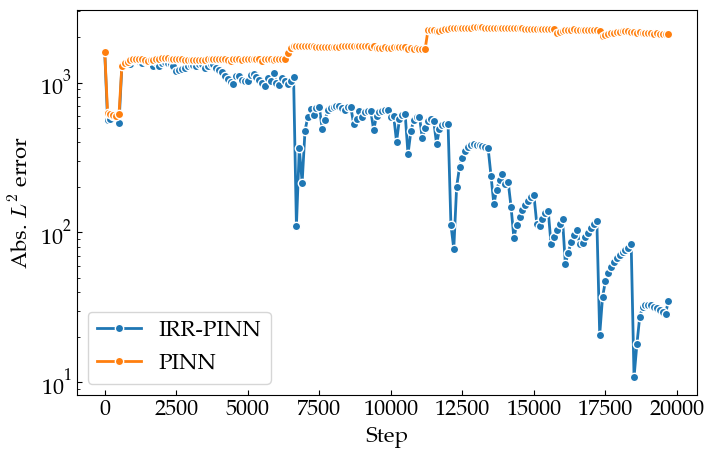

In [8]:
import pandas as pd

error_log = pd.read_csv("./logs-eval/run-combustion_irr_0718-baseline-19800-tag-error.csv")
error_log_noirr = pd.read_csv("./logs-eval/run-combustion_noirr_0718-baseline-tag-error.csv")

error_log = error_log[error_log["Step"] < 19800]
error_log_noirr = error_log_noirr[error_log_noirr["Step"] < 19800]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(error_log["Step"], error_log["Value"], label="IRR-PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1,)
ax.plot(error_log_noirr["Step"], error_log_noirr["Value"], label="PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1,)
ax.set(ylabel="Abs. $L^2$ error", xlabel="Step", yscale="log")
ax.legend(loc="lower left",)
# plt.savefig("figures/combustion-error-log.png", dpi=300, bbox_inches="tight")

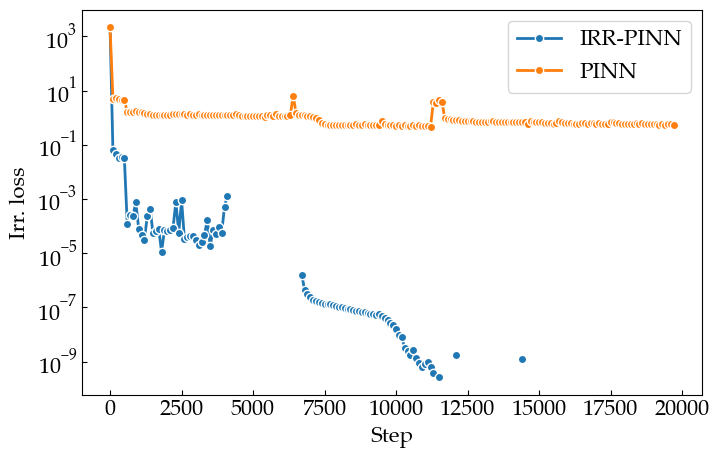

In [9]:

loss_log = pd.read_csv("./logs-eval/run-combustion_irr_0718-baseline-19800-tag-loss_irr.csv")
loss_log_noirr = pd.read_csv("./logs-eval/run-combustion_noirr_0718-baseline-tag-loss_irr.csv")

loss_log["Value"] = loss_log["Value"].apply(lambda x : jnp.nan if jnp.abs(x) < 1e-10 else x)
loss_log = loss_log[loss_log["Step"] < 19800]
loss_log_noirr = loss_log_noirr[loss_log_noirr["Step"] < 19800]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(loss_log["Step"], loss_log["Value"], label="IRR-PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(loss_log_noirr["Step"], loss_log_noirr["Value"], label="PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="Irr. loss", xlabel="Step", yscale="log")
ax.legend(loc="upper right",)
plt.savefig("figures/combustion-irrloss-log.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/combustion-irrloss-log.pdf", dpi=300, bbox_inches="tight")